In [1]:
import sys
sys.path.insert(0, '../../../pyLDLE2/')
sys.path.insert(0, '../src/')

import numpy as np
import networkx as nx
import ConnectionNetworkX as cnx

from matplotlib import pyplot as plt
from matplotlib import cm

from pyLDLE2 import datasets, visualize_

matplotlib.get_backend() =  module://matplotlib_inline.backend_inline


In [2]:
import importlib
importlib.reload(cnx)

<module 'ConnectionNetworkX' from '/home/dhruv/codebase/cgw/connection-graph-wasserstein/nbks/../src/ConnectionNetworkX.py'>

In [3]:
def draw3d(G, pos, node_color, node_size, edge_color, edge_width=1, figsize=(8,4)):
    # Extract node and edge positions from the layout
    node_xyz = np.array([pos[v] for v in sorted(G)])
    edge_xyz = np.array([(pos[u], pos[v]) for u, v in G.edges()])

    # Create the 3D figure
    fig = plt.figure(figsize=figsize, constrained_layout=True)
    ax = fig.add_subplot(111, projection="3d")

    # Plot the nodes - alpha is scaled by "depth" automatically
    ax.scatter(*node_xyz.T, c=node_color, s=node_size, ec="w")

    # Plot the edges
    for i in range(edge_xyz.shape[0]):
        vizedge = edge_xyz[i,:]
        direction = [vizedge[1,0]-vizedge[0,0],
                     vizedge[1,1]-vizedge[0,1],
                     vizedge[1,2]-vizedge[0,2]]
        direction = np.array(direction)
        edge_length = np.linalg.norm(direction)
        direction = direction/edge_length
        ax.quiver(vizedge[0,0], vizedge[0,1], vizedge[0,2],
                  direction[0], direction[1], direction[2],
                  length=edge_length, color=edge_color[i])
        #ax.plot(*vizedge.T, color=edge_color[i], linewidth=edge_width)

    visualize_.set_axes_equal(ax)
    ax.set_xlim(np.min(node_xyz[:,0]), np.max(node_xyz[:,0]))
    ax.set_ylim(np.min(node_xyz[:,1]), np.max(node_xyz[:,1]))
    ax.set_zlim(np.min(node_xyz[:,2]), np.max(node_xyz[:,2]))
    ax.axis('off')
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
    plt.margins(0)
    plt.gca().xaxis.set_major_locator(plt.NullLocator())
    plt.gca().yaxis.set_major_locator(plt.NullLocator())

# Load data

In [4]:
X, labelsMat, _ = datasets.Datasets().curvedtorus3d(n=3000)

X.shape =  (3000, 3)


<IPython.core.display.Javascript object>


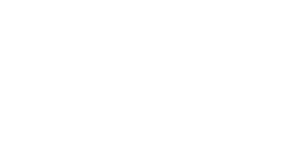

In [5]:
%matplotlib notebook
vis = visualize_.Visualize()
vis.data(X, labelsMat[:,0], cmap='hsv', figsize=(4,4))

# Set source and destination nodes

In [55]:
source = 1300
dest1 = 100
dest2 = 1929

<IPython.core.display.Javascript object>


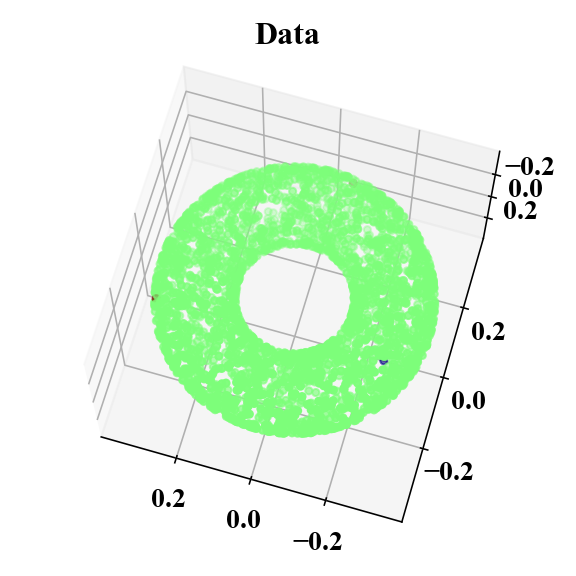

In [56]:
%matplotlib notebook
vis = visualize_.Visualize()
labels = np.zeros(X.shape[0])
labels[source] = -1
labels[dest1] = 1
labels[dest2] = 1
vis.data(X, labels, cmap='jet', figsize=(4,4), s=50, elev=30, azim=130)

#  Build connection graph

In [57]:
eps_pca = 0.03
eps = eps_pca
d = 2
CG = cnx.cnxFromData(X, eps_pca, eps, d=d, tol=1, triv_sigma=True)

Total edges before removal: 12613


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:00<00:00, 7858.71it/s]


Proportion of edges which were removed due to remoteness:  0.0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [01:16<00:00, 39.14it/s]


# Set B, w, mu, nu, c

In [58]:
n = CG.number_of_nodes()

B = CG.B.T.astype('float32')
w = np.array(list(nx.get_edge_attributes(CG, 'weight').values()))

mu = np.zeros((n * d, 1))
nu = np.zeros((n * d, 1))
mu[source * d: (source + 1) * d, :] = 1
nu[dest1 * d, :] = 1
nu[dest2 * d+1, :] = 1

c = (mu - nu)

# Plot c

<IPython.core.display.Javascript object>


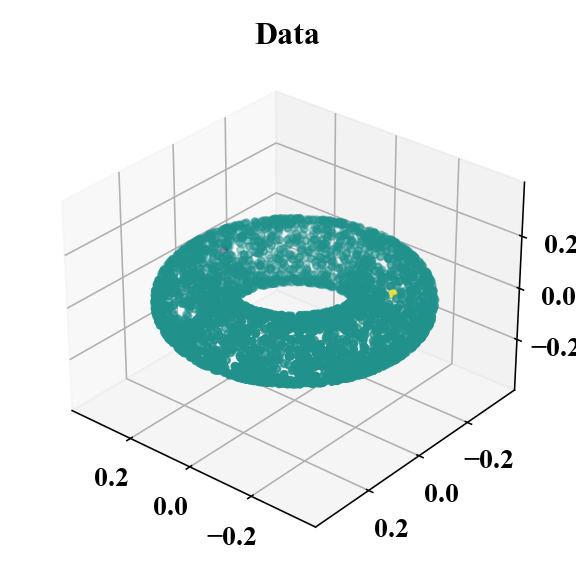

<IPython.core.display.Javascript object>


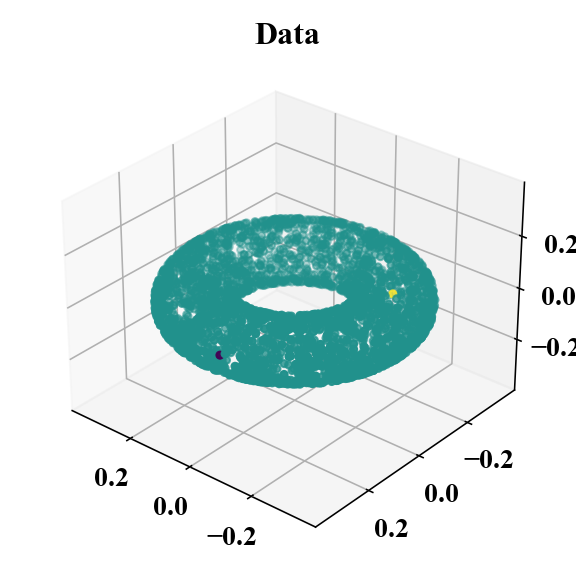

In [59]:
%matplotlib notebook
vis = visualize_.Visualize()
vis.data(X, c.reshape((n,d))[:,0], cmap='viridis', figsize=(4,4), s=50, elev=30, azim=130)
vis.data(X, c.reshape((n,d))[:,1], cmap='viridis', figsize=(4,4), s=50, elev=30, azim=130)

# Check feasibility of primal i.e. $B^TJ = c$

In [60]:
temp_J, residuals, _, _ = np.linalg.lstsq(B.T.toarray(), c, rcond=None)
print('Error is:', np.linalg.norm(c.flatten() - B.T.dot(temp_J).flatten())) # if this is small then feasible

Error is: 1.689230327343147e-14


# Solve Beckmann dual using gradient descent

In [61]:
learning_rate = 0.1
alpha = np.max(w)
n_epochs = 5000

phi, phi0 = cnx.optimize_(B, w, c, learning_rate=learning_rate, alpha=alpha,
                    n_epochs=n_epochs, phi0='least_squares')

Initial loss: (tensor(-12.8529), tensor(4.3425))
epoch: 0, loss: 0.065285, loss0: -12.852889, loss1: 4.342545
epoch: 10, loss: -9.291102, loss0: -10.233866, loss1: 0.316917
epoch: 20, loss: -9.943127, loss0: -10.137527, loss1: 0.065349
epoch: 30, loss: -10.840092, loss0: -11.304364, loss1: 0.156069
epoch: 40, loss: -11.713739, loss0: -12.413257, loss1: 0.235148
epoch: 50, loss: -12.486162, loss0: -13.294201, loss1: 0.271629
epoch: 60, loss: -13.176231, loss0: -14.094447, loss1: 0.308665
epoch: 70, loss: -13.980800, loss0: -14.855618, loss1: 0.294077
epoch: 80, loss: -14.695715, loss0: -15.617157, loss1: 0.309750
epoch: 90, loss: -15.386086, loss0: -16.352711, loss1: 0.324938
epoch: 100, loss: -16.022612, loss0: -17.057009, loss1: 0.347721
epoch: 110, loss: -16.588001, loss0: -17.666075, loss1: 0.362403
epoch: 120, loss: -17.130198, loss0: -18.259392, loss1: 0.379588
epoch: 130, loss: -17.581379, loss0: -18.814884, loss1: 0.414652
epoch: 140, loss: -18.013203, loss0: -19.338985, loss1: 

epoch: 1260, loss: -23.348152, loss0: -26.131618, loss1: 0.935684
epoch: 1270, loss: -23.344011, loss0: -26.135406, loss1: 0.938349
epoch: 1280, loss: -23.341593, loss0: -26.136913, loss1: 0.939669
epoch: 1290, loss: -23.342489, loss0: -26.135944, loss1: 0.939042
epoch: 1300, loss: -23.330647, loss0: -26.134464, loss1: 0.942525
epoch: 1310, loss: -23.131580, loss0: -26.132372, loss1: 1.008739
epoch: 1320, loss: -22.863764, loss0: -26.127024, loss1: 1.096970
epoch: 1330, loss: -23.022598, loss0: -25.938625, loss1: 0.980245
epoch: 1340, loss: -23.135220, loss0: -25.975386, loss1: 0.954744
epoch: 1350, loss: -23.161209, loss0: -26.022514, loss1: 0.961850
epoch: 1360, loss: -23.164526, loss0: -26.017567, loss1: 0.959072
epoch: 1370, loss: -23.132929, loss0: -25.993290, loss1: 0.961532
epoch: 1380, loss: -23.051842, loss0: -26.043999, loss1: 1.005837
epoch: 1390, loss: -22.934763, loss0: -26.014957, loss1: 1.035432
epoch: 1400, loss: -23.174961, loss0: -26.007357, loss1: 0.952132
epoch: 141

epoch: 2520, loss: -23.346016, loss0: -26.146034, loss1: 0.941248
epoch: 2530, loss: -23.342268, loss0: -26.145905, loss1: 0.942464
epoch: 2540, loss: -23.338079, loss0: -26.146544, loss1: 0.944087
epoch: 2550, loss: -23.327135, loss0: -26.146376, loss1: 0.947710
epoch: 2560, loss: -23.337130, loss0: -26.144878, loss1: 0.943847
epoch: 2570, loss: -23.340889, loss0: -26.142971, loss1: 0.941942
epoch: 2580, loss: -23.331314, loss0: -26.142612, loss1: 0.945040
epoch: 2590, loss: -23.167974, loss0: -26.144930, loss1: 1.000727
epoch: 2600, loss: -22.357317, loss0: -26.063248, loss1: 1.245777
epoch: 2610, loss: -22.905516, loss0: -25.992147, loss1: 1.037596
epoch: 2620, loss: -22.404745, loss0: -25.951517, loss1: 1.192275
epoch: 2630, loss: -22.856949, loss0: -25.699947, loss1: 0.955696
epoch: 2640, loss: -23.051304, loss0: -25.763556, loss1: 0.911745
epoch: 2650, loss: -22.902290, loss0: -25.832108, loss1: 0.984881
epoch: 2660, loss: -22.769558, loss0: -25.863890, loss1: 1.040183
epoch: 267

epoch: 3780, loss: -23.361710, loss0: -26.153051, loss1: 0.938331
epoch: 3790, loss: -23.363230, loss0: -26.155935, loss1: 0.938790
epoch: 3800, loss: -23.362154, loss0: -26.156944, loss1: 0.939490
epoch: 3810, loss: -23.360102, loss0: -26.156580, loss1: 0.940058
epoch: 3820, loss: -23.362236, loss0: -26.156698, loss1: 0.939381
epoch: 3830, loss: -23.360498, loss0: -26.157578, loss1: 0.940260
epoch: 3840, loss: -23.358898, loss0: -26.158363, loss1: 0.941062
epoch: 3850, loss: -23.358955, loss0: -26.158440, loss1: 0.941068
epoch: 3860, loss: -23.356022, loss0: -26.160585, loss1: 0.942776
epoch: 3870, loss: -23.355818, loss0: -26.158344, loss1: 0.942091
epoch: 3880, loss: -23.357988, loss0: -26.158556, loss1: 0.941433
epoch: 3890, loss: -23.357992, loss0: -26.158470, loss1: 0.941402
epoch: 3900, loss: -23.354994, loss0: -26.159512, loss1: 0.942760
epoch: 3910, loss: -23.347164, loss0: -26.156801, loss1: 0.944482
epoch: 3920, loss: -23.353201, loss0: -26.157080, loss1: 0.942545
epoch: 393

# Compute activeness of edges and optimal primal

In [62]:
edge_score = cnx.activenes_of_edges(phi, B, w, c)
J_opt = cnx.optimal_primal(phi, B, w, c, alpha, d) # the mean abs error should be small

mean abs err of sum_{v in V} ||(B^TJ-c)(v)||_1 0.0035594206711144815


In [63]:
J_opt_norm = np.linalg.norm(J_opt, axis=1)

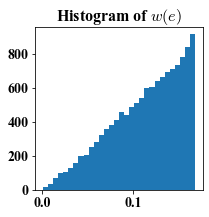

In [64]:
%matplotlib inline
plt.figure(figsize=(3,3))
plt.hist(list(nx.get_edge_attributes(CG, "weight").values()), bins=30)
plt.title('Histogram of $w(e)$')
plt.show()

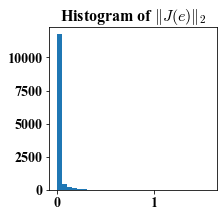

In [65]:
%matplotlib inline
plt.figure(figsize=(3,3))
plt.hist(J_opt_norm, bins=30)
plt.title('Histogram of $\\left\\|J(e)\\right\\|_2$')
plt.show()

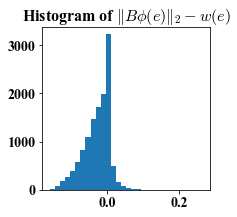

In [66]:
%matplotlib inline
plt.figure(figsize=(3,3))
plt.hist(edge_score, bins=30)
plt.title('Histogram of $\\left\\|B\\phi(e)\\right\\|_2-w(e)$')
plt.show()

# Plot optimal flow

In [67]:
from sklearn.manifold import LocallyLinearEmbedding, Isomap

to_embed = None # no need to embed if the data is already in <= 3 dimensions, else use isomap/ltsa
embed_dim = None
if to_embed is not None:
    if to_embed == 'isomap':
        fit_obj = Isomap(n_components=embed_dim, n_neighbors=10)
    else:
        fit_obj = LocallyLinearEmbedding(n_components=embed_dim, n_neighbors=10, method='ltsa')
    embedding = fit_obj.fit_transform(X)
else:
    embedding = X

In [68]:
J = J_opt

<IPython.core.display.Javascript object>


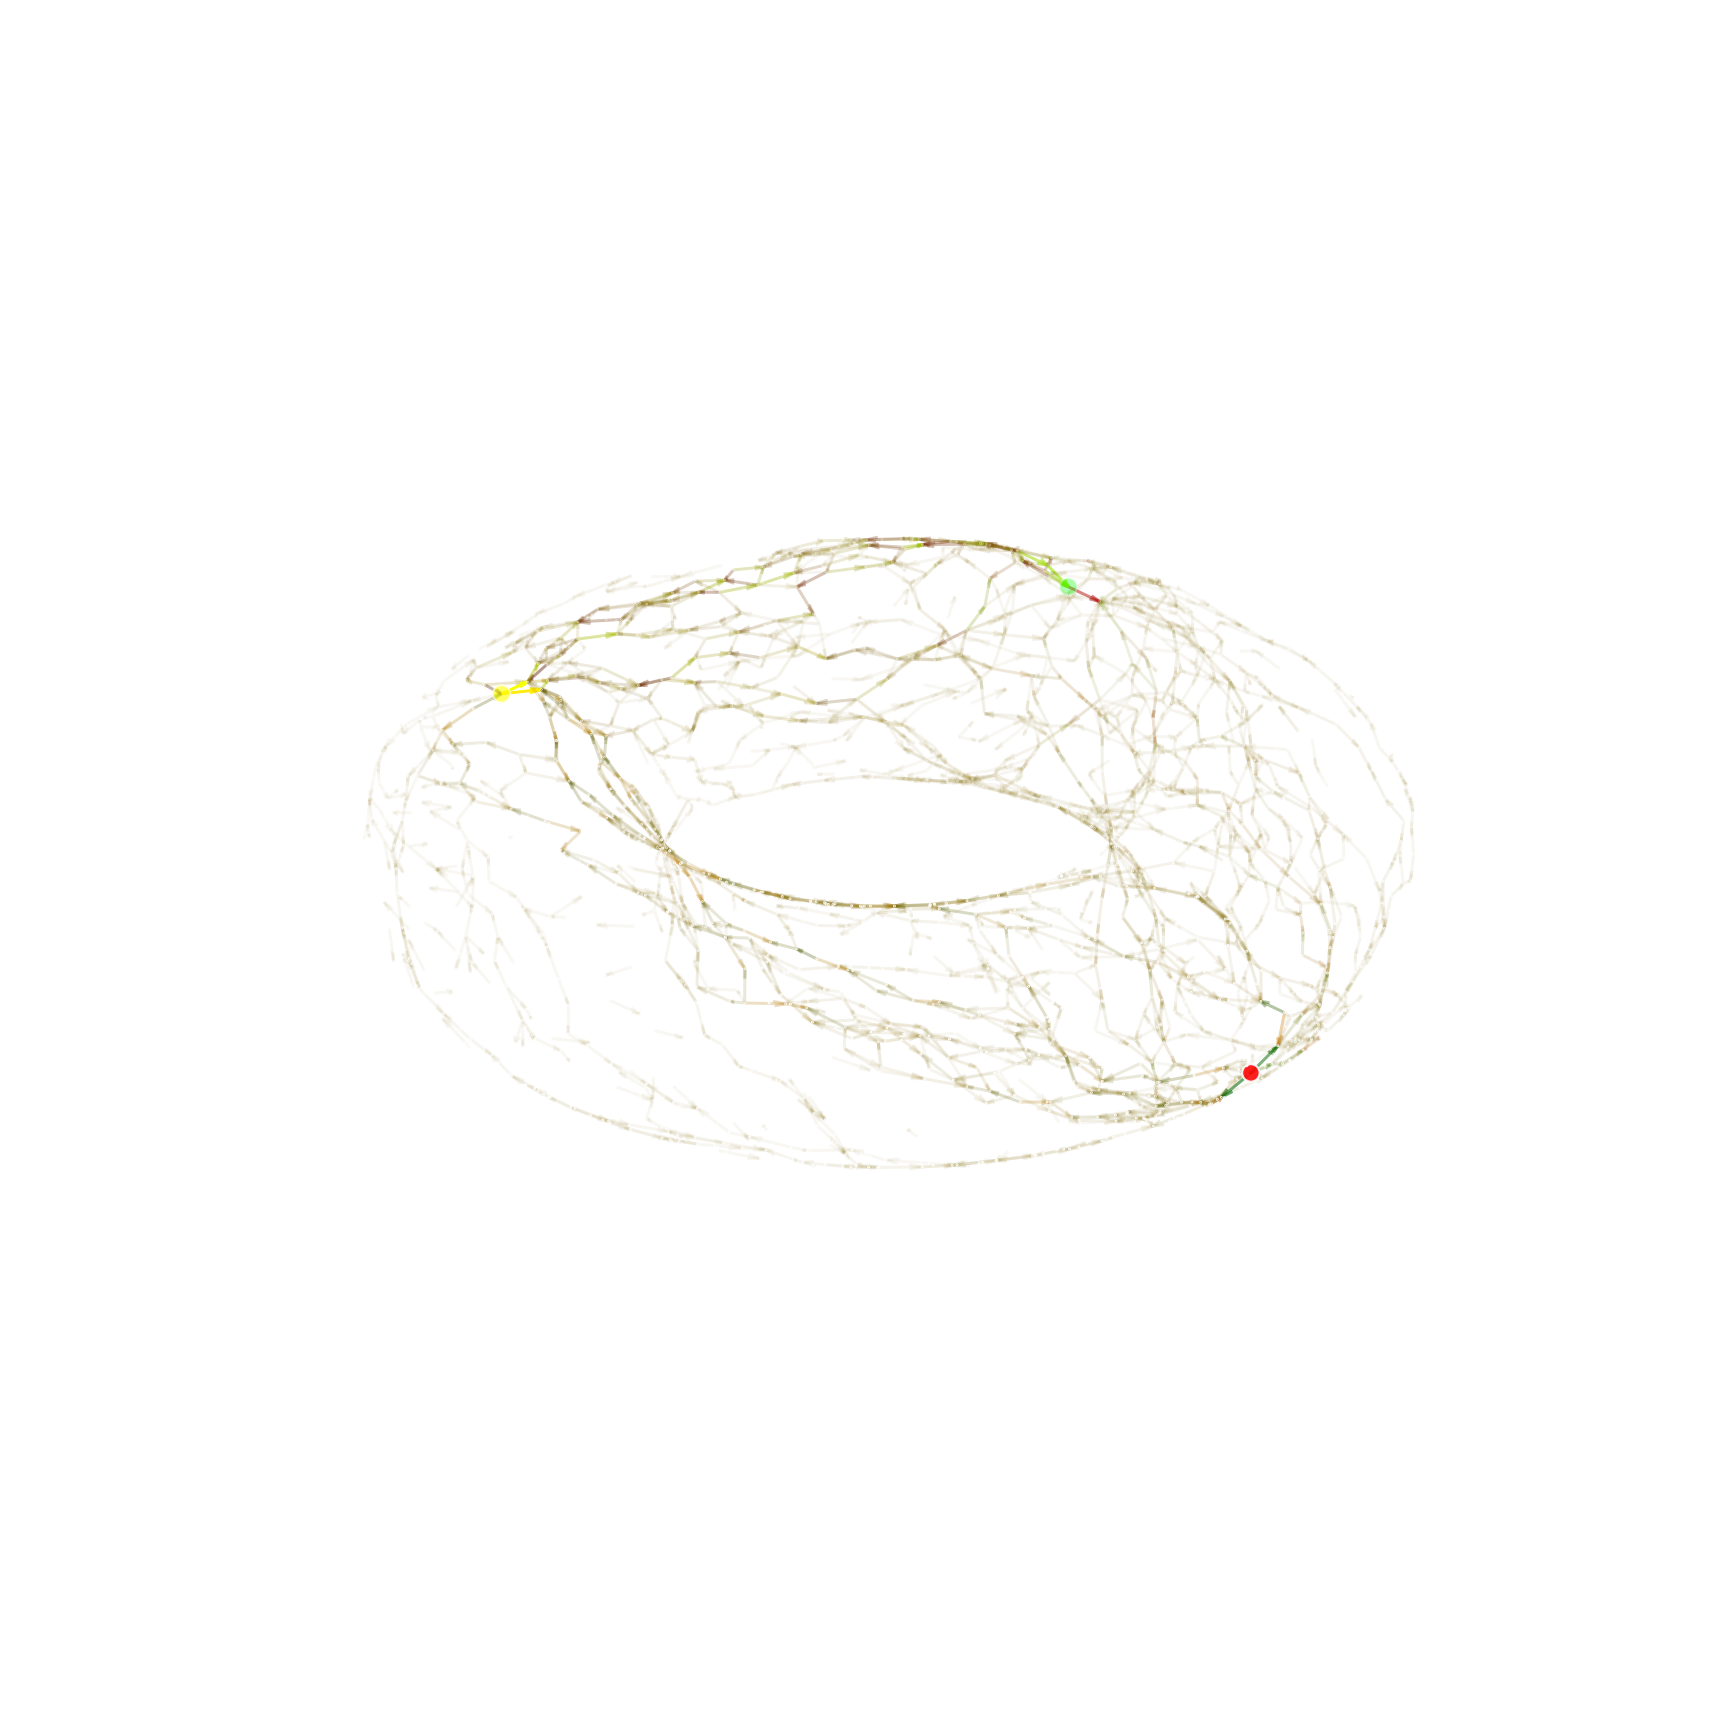

/tmp/ipykernel_59443/1841123288.py:32: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(left=0, right=1, bottom=0, top=1)


In [73]:
%matplotlib notebook

node_size = np.ones(n)*1
node_size[source] = 300
node_size[dest1] = 300
node_size[dest2] = 300

node_color = np.zeros((n,4))
node_color[:,:3] = 1
node_color[source,:] = [1,1,0,1]
node_color[dest1] = [1,0,0,1]
node_color[dest2] = [0,1,0,1]

mask = (edge_score > 0)
J_ = J[mask,:]

edge_color = np.zeros((J.shape[0],4))
edge_color[mask,0] = cm.Greys((J_[:,0]-np.min(J_[:,0]))/np.ptp(J_[:,0]))[:,0]
edge_color[mask,1] = cm.Greys((J_[:,1]-np.min(J_[:,1]))/np.ptp(J_[:,1]))[:,1]
edge_color[mask,-1] = 0.05 + 0.95*(edge_score[mask]-np.min(edge_score[mask]))/np.ptp(edge_score[mask])

draw3d(CG, embedding, node_color, node_size, edge_color, edge_width=5, figsize=(12, 12))
#plt.gca().view_init(elev=20, azim=-119)
visualize_.set_axes_equal(plt.gca())
plt.show()

<IPython.core.display.Javascript object>


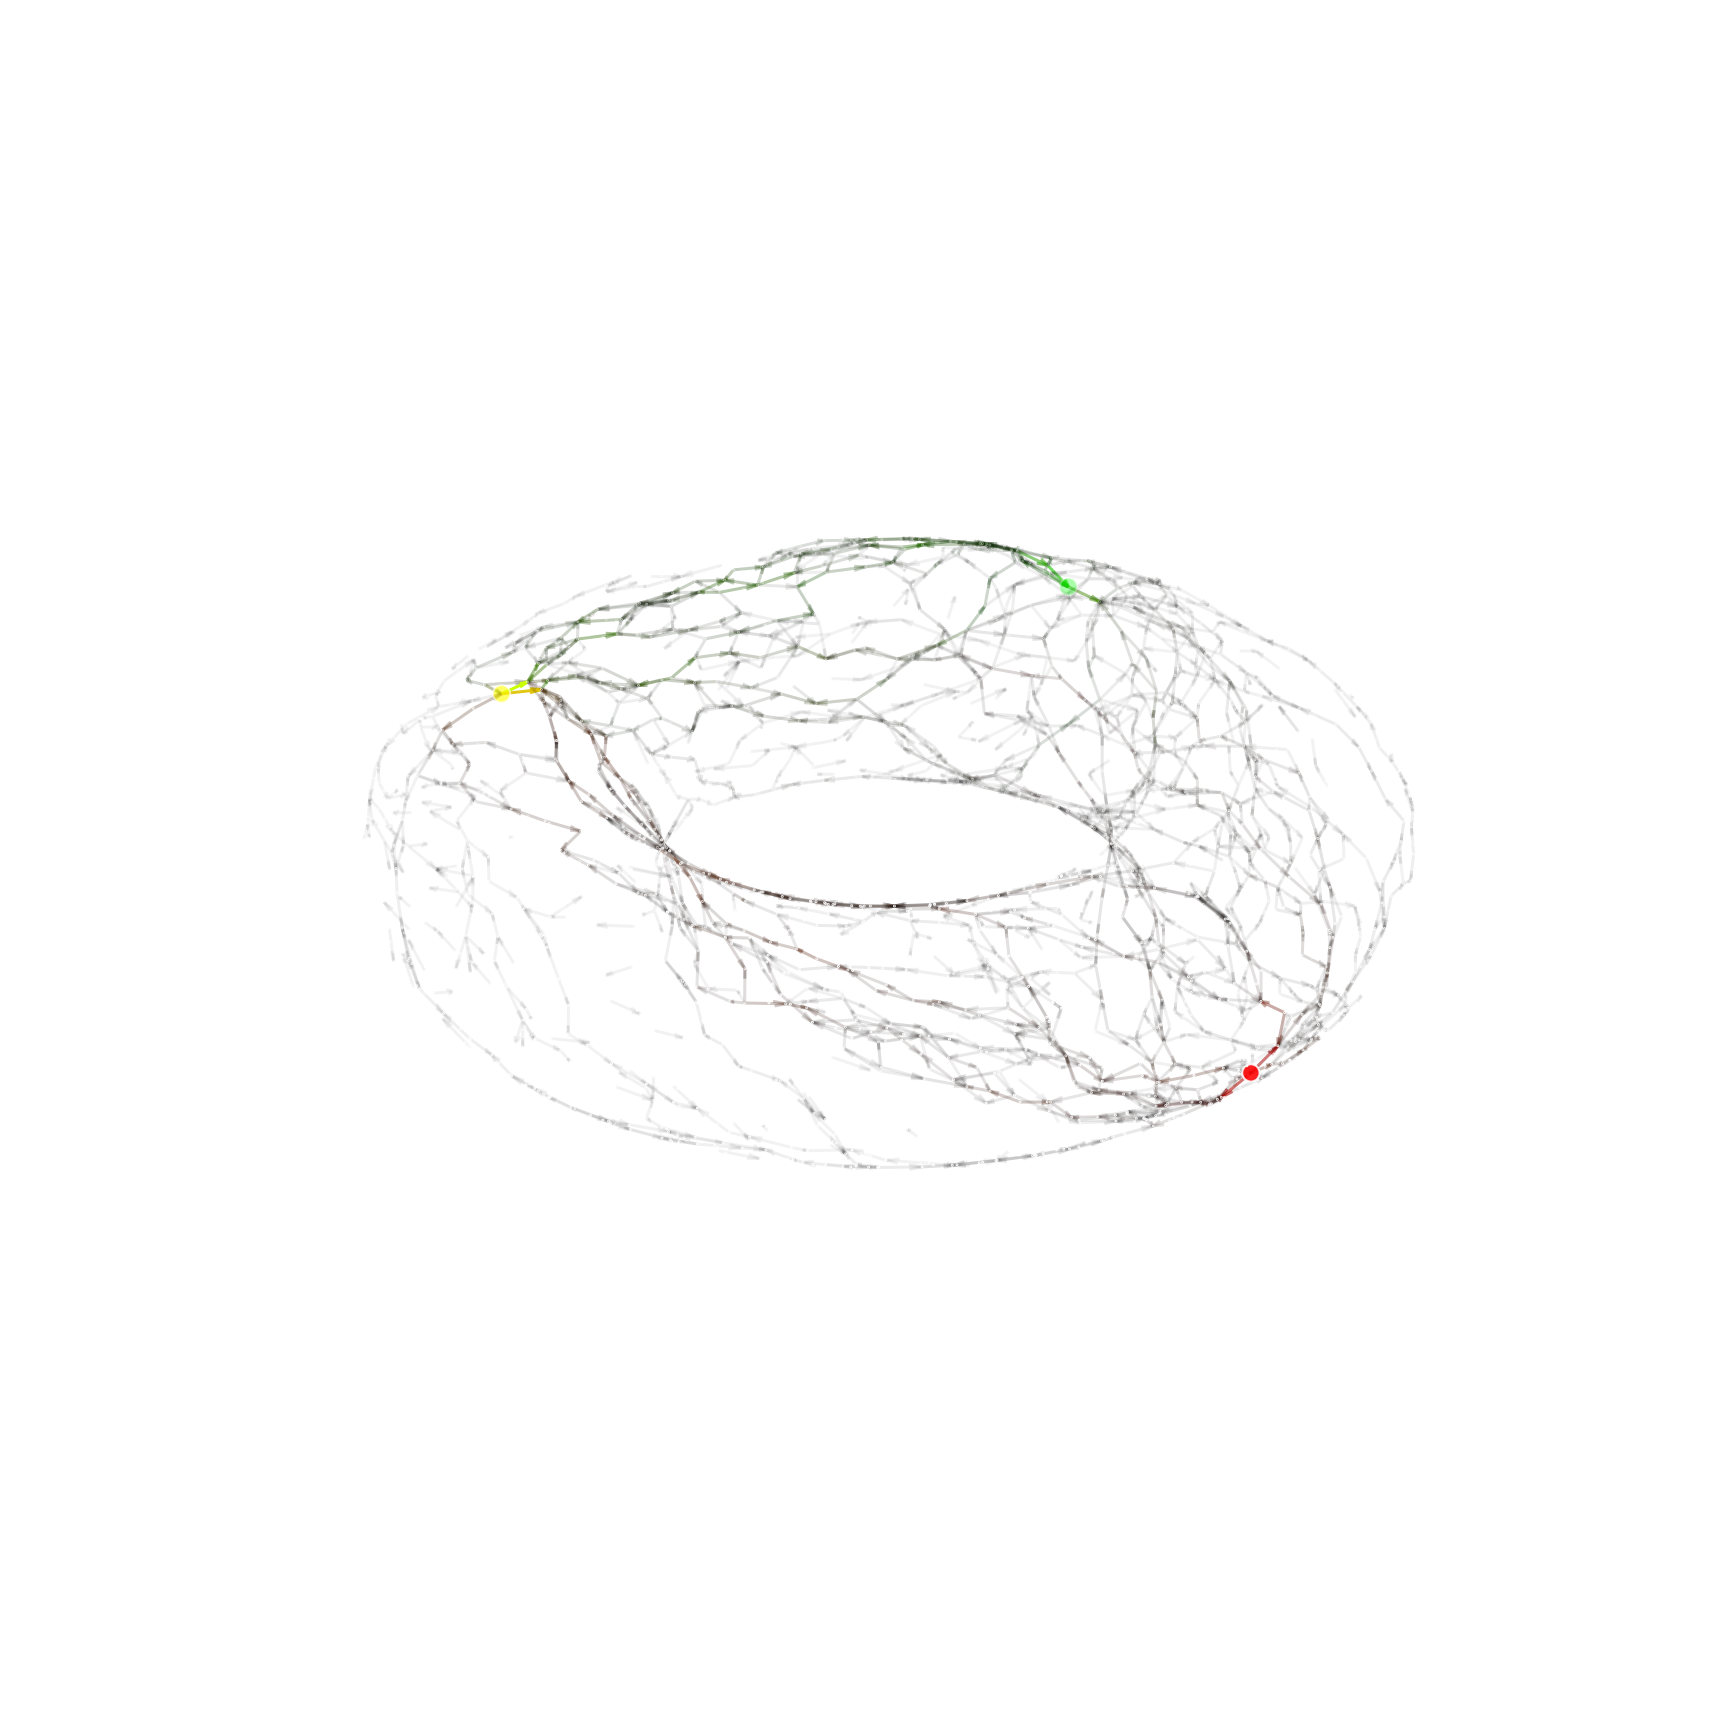

/tmp/ipykernel_59443/1841123288.py:32: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(left=0, right=1, bottom=0, top=1)


In [74]:
%matplotlib notebook
node_size = np.ones(n)*1
node_size[source] = 300
node_size[dest1] = 300
node_size[dest2] = 300

node_color = np.zeros((n,4))
node_color[:,:3] = 1
node_color[source,:] = [1,1,0,1]
node_color[dest1] = [1,0,0,1]
node_color[dest2] = [0,1,0,1]

mask = (edge_score > 0)
J_ = J[mask,:]
mJ_ = np.max(np.abs(J_))

edge_color = np.zeros((J.shape[0],4))
edge_color[mask,0] = np.abs(J_[:,0])/mJ_
edge_color[mask,1] = np.abs(J_[:,1])/mJ_
edge_color[mask,-1] = 0.05 + 0.95*(edge_score[mask]-np.min(edge_score[mask]))/np.ptp(edge_score[mask])

draw3d(CG, embedding, node_color, node_size, edge_color, edge_width=5, figsize=(12, 12))
#plt.gca().view_init(elev=20, azim=-119)
visualize_.set_axes_equal(plt.gca())
plt.show()

# Plot optimal phi

In [75]:
node_color_ = phi.reshape((CG.number_of_nodes(), d))

<IPython.core.display.Javascript object>


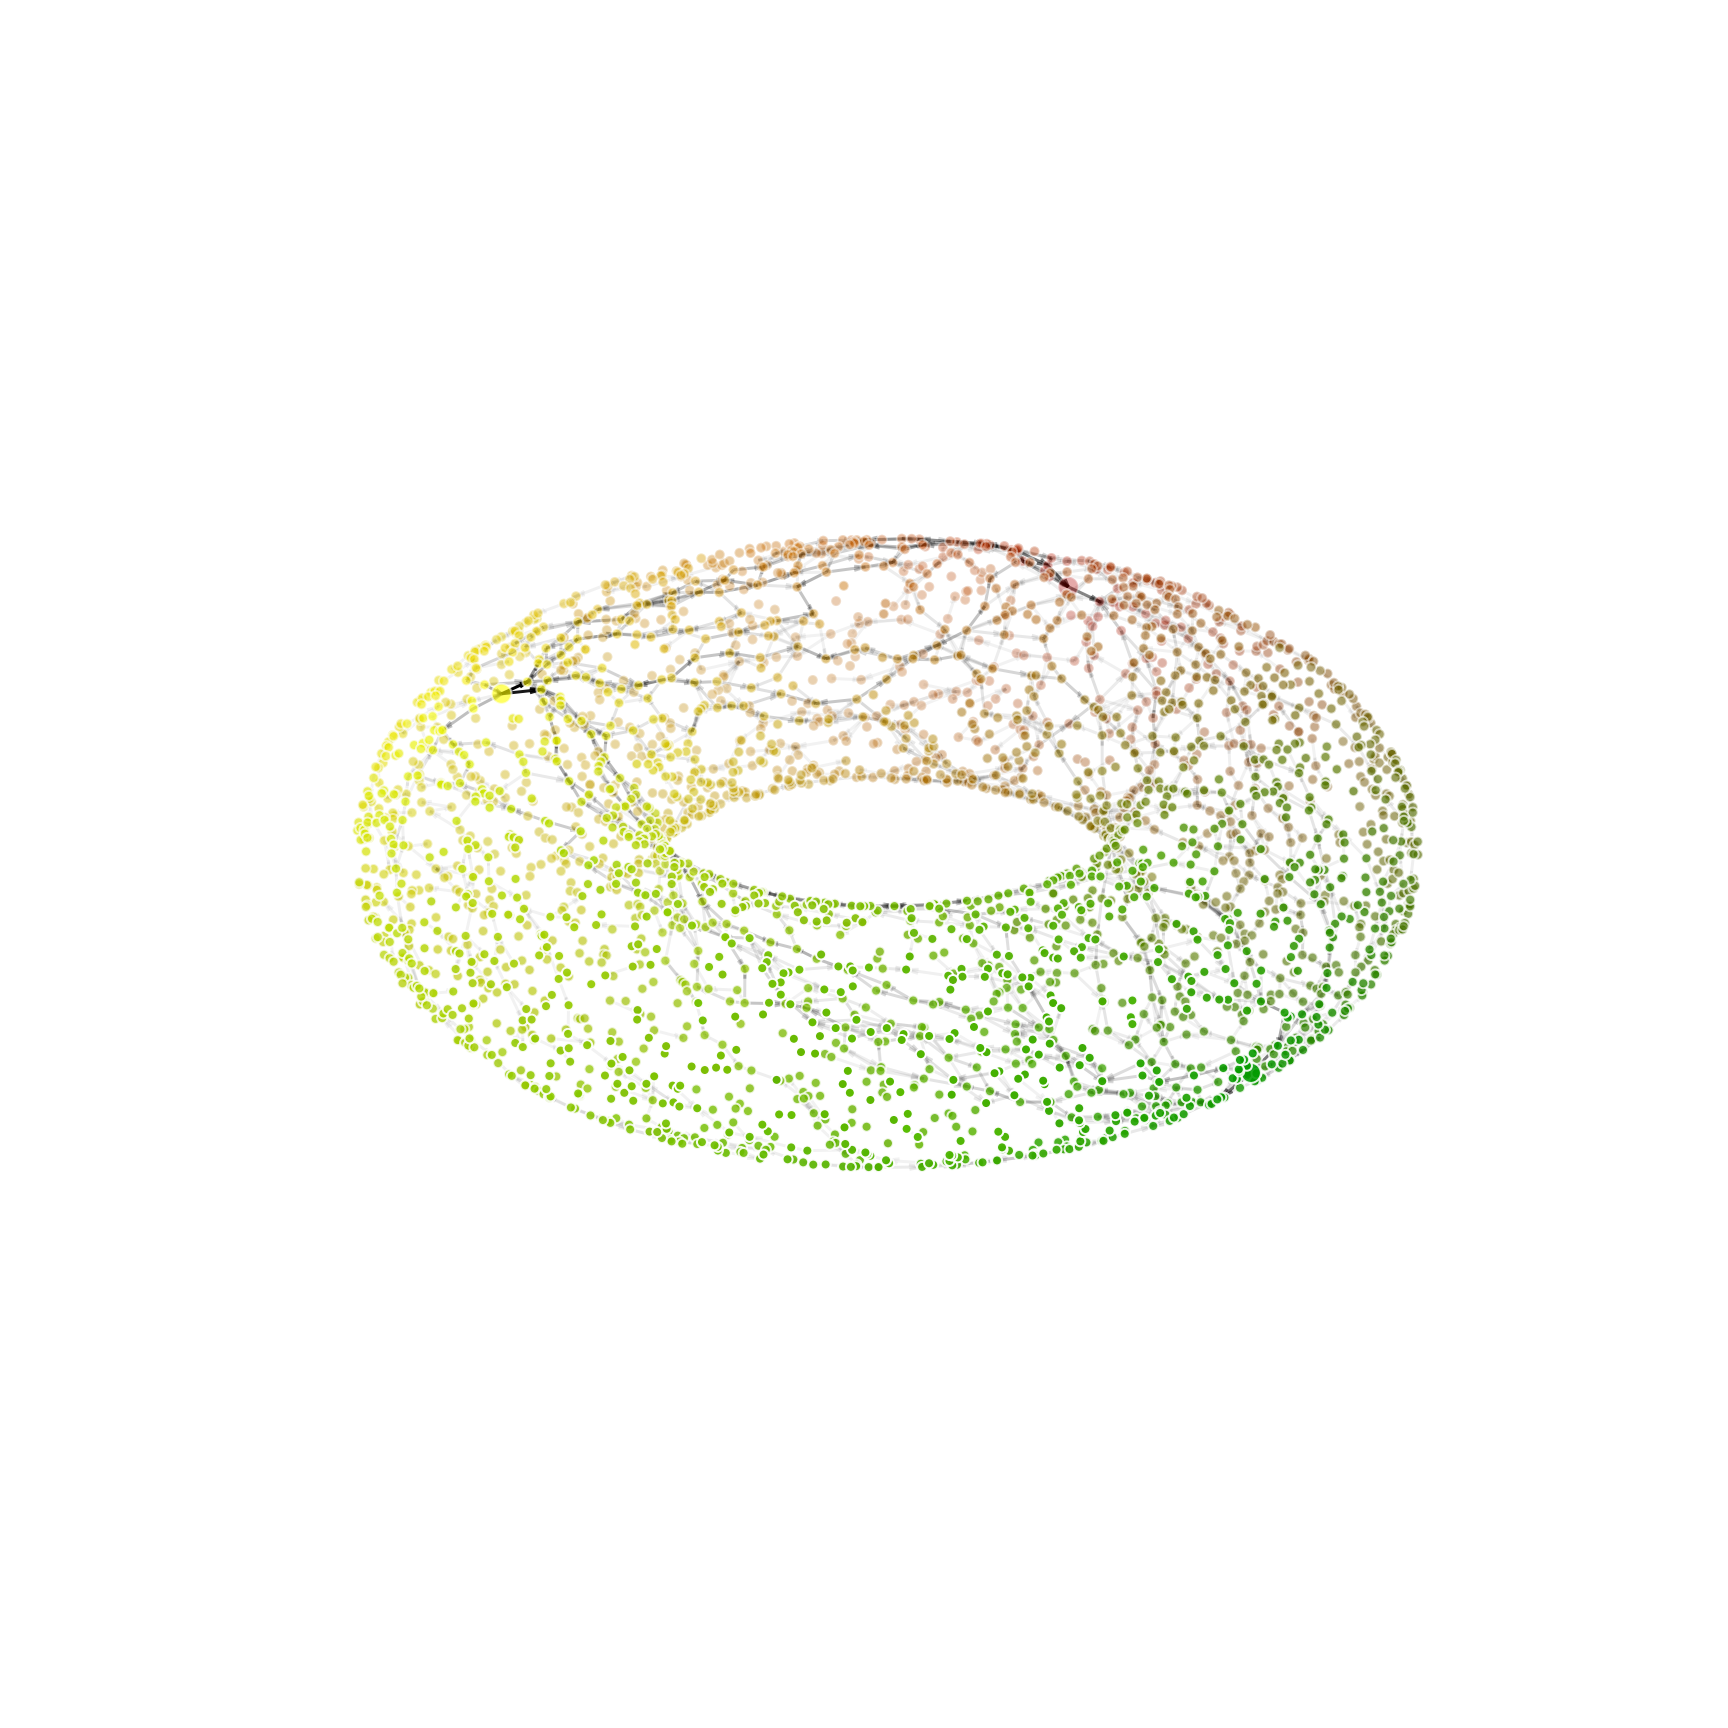

/tmp/ipykernel_59443/1841123288.py:32: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(left=0, right=1, bottom=0, top=1)


In [79]:
%matplotlib notebook
node_size = np.ones(n)*100
node_size[source] = 400
node_size[dest1] = 400
node_size[dest2] = 400

node_color = np.zeros((n,4))
node_color[:,-1] = 1
node_color[:,0] = (node_color_[:,0] - np.min(node_color_[:,0]))/np.ptp(node_color_[:,0])
node_color[:,1] = (node_color_[:,1] - np.min(node_color_[:,1]))/np.ptp(node_color_[:,1])

mask = (edge_score > 0)

edge_color = np.zeros((edge_score.shape[0],4))
edge_color[mask,-1] = 0.05 + 0.95*(edge_score[mask]-np.min(edge_score[mask]))/np.ptp(edge_score[mask])

draw3d(CG, embedding, node_color, node_size, edge_color, edge_width=5, figsize=(12, 12))
#plt.gca().view_init(elev=20, azim=-119)
visualize_.set_axes_equal(plt.gca())
plt.show()